In [1]:
import os
import sys
from pathlib import Path # if you haven't already done so
file = Path(os.getcwd()).resolve()
parent, root = file.parent, file.parents[1]
print(parent, root)
sys.path.append(str(parent))
# sys.path.append("..")

# # Additionally remove the current file's directory from sys.path
# try:
#     sys.path.remove(str(parent))
# except ValueError: # Already removed
#     pass

/root/fruitao/drone/logic_guided_prompt/code /root/fruitao/drone/logic_guided_prompt


In [2]:
from drone_train import *

/root/fruitao/drone/logic_guided_prompt/code/data_augmentation /root/fruitao/drone/logic_guided_prompt/code


/root/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_file_li=[r"../../text_annotation/desert.xlsx", r"../../text_annotation/disturbance.xlsx", r"../../text_annotation/factory.xlsx", r"../../text_annotation/island.xlsx", 
                 r"../../text_annotation/misc.xlsx", r"../../text_annotation/ocean.xlsx", r"../../text_annotation/rural.xlsx", r"../../text_annotation/urban.xlsx"
]

In [4]:
old_data_dic=load_sensor_data(dataset_file_li)

templates:{'flying_not_normal_frame': ['The drone is flying with a damaged frame.'], 'near_moving_object': ["(0:01) The drone is risking physical damage. It's flying too close to the moving car at a distance of 3.0m.", "(0:05) The drone is risking physical damage. It's flying too close to the moving car at a distance of 0.3m."], 'reachable_inpath': ["(0:05) The drone is facing the risk of physical damage. There is a car in the drone's flight path at a distance of 0.3m."]}
templates:{'near_moving_object': ["(0:01) The drone is risking physical damage. It's flying too close to the moving car at a distance of 3.0m.", "(0:03) The drone is risking physical damage. It's flying too close to the moving car at a distance of 0.2m."], 'reachable_inpath': ["(0:03) The drone is facing the risk of physical damage. There is a car in the drone's flight path at a distance of 0.2m."]}
templates:{'flying_not_normal_frame': ['The drone is flying with a damaged frame.'], 'near_moving_object': ["(0:03) The 

In [5]:
(text_li, all_status_dic_li, all_timestep_dic_li, all_sensor_data_li), (templates_li, related_sensor_data_li), oneshot_examples_li=read_data_dict(old_data_dic)

In [6]:
print(len(text_li), text_li[0])
print(len(all_status_dic_li), all_status_dic_li[0])
print(len(all_timestep_dic_li), all_timestep_dic_li[0])
print(len(all_sensor_data_li), all_sensor_data_li[0])

300 [{'Text1': "Risk of physical damage! The drone has a damaged frame. [SEP]\n(0:05) Risk of physical damage! There's a car in the drone's flight path at a distance of .3m. [SEP]", 'Text2': "Risk of physical damage! The drone's frame is in need of repair. [SEP]\n(0:05) Risk of physical damage! In .3m there's a car in the flight path. [SEP]"}]
300 [{'WindSpeed (m/s)': 0, 'DroneSpeed (m/s)': 0.5, 'PilotExperienced': True, 'Altitude (m)': 0.5, 'Temperature (celcius)': 41, 'Distance_from_remote_control (m)': 96, 'Battery_level': 90, 'Low_visibility': False, 'Normal_frame': False, 'weather': 'sunny', 'upside_down': False, 'good_motor_condition': True, 'going_backwards': False, 'indoor': False, 'waterproof drone?': False, 'flying over': 'ground', 'criticality': 'warning', 'RiskOfPhysicalDamage': nan, 'RiskOfInternalDamage': False, 'RiskOfHumanDamage': False, 'LostConnection': False}]
300 [{'name': 'car', 'ID_obj': 1.0, 'Type': 'Car', 'Moving': False, 'InPath': False, 'Distance': 3.0, 'time_

In [7]:
print(len(templates_li), templates_li[0])
print(len(related_sensor_data_li), related_sensor_data_li[0])

1652 The drone is flying with a damaged frame.
1652 {"Normal_frame": false}


In [8]:
train_sensor_data, test_sensor_data=train_test_split(related_sensor_data_li)
train_templates, test_templates=train_test_split(templates_li)

# Train

In [9]:
!nvidia-smi

Tue Jun 13 02:09:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   47C    P0    94W / 300W |  39641MiB / 81920MiB |     49%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  On   | 00000000:22:00.0 Off |                    0 |
| N/A   

In [12]:
import torch
import math

from tqdm import tqdm
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch.nn as nn
from sklearn.metrics import accuracy_score
from nltk.translate import meteor_score



In [13]:
device=torch.device("cuda:2")
torch.manual_seed(3407)

In [14]:
# n_tokens = 20

model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

initialize_from_vocab = True
batch_size = 32
n_epoch = 200

use_ce_loss = False
ce_loss = nn.CrossEntropyLoss()

n_tokens = len(WARNING_DL)
s_wte = SoftEmbedding(model.get_input_embeddings(), 
                      n_tokens=n_tokens, 
                      initialize_from_vocab=initialize_from_vocab)
model.set_input_embeddings(s_wte)

optimizer = torch.optim.Adam(s_wte.parameters(), lr=0.5)

metrics_file='metrics_epoch_LGP_soft_prompt_200_3407.csv'

from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d%m_%H%M%S")
save_model_file="./output/LGP_soft_prompt_200_3407_"+dt_string

if torch.cuda.is_available():
    model = model.to(device)


In [15]:
parameters = list(model.parameters())
for x in parameters[1:]:
    x.requires_grad = False

In [17]:
for x, y, m, dii, true_labels in generate_data(4, n_tokens, related_sensor_data_li, templates_li, tokenizer, device):
    assert dii.shape == y.shape
    outputs = model(input_ids=x, labels=y, attention_mask=m, decoder_input_ids=dii)
    assert outputs['logits'].shape[:2] == y.shape
    pred_labels = outputs['logits'][:, :, :].argmax(-1).detach().cpu().numpy()
    print("pred_labels:{}".format((pred_labels, pred_labels.shape)))
    break

pred_labels:(array([[    0,     2,     2,     2,     5,     6,     7,     8,     9,
           10,    11,    12,    13,    14,    15,    16,    17,    27,
           19,    20,    21,    22, 49643,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2],
       [    0,   133,     2,     2,     2,     6,     7,     8,     9,
           10,    11,    12,    13,    14,    15,    16,    17,    27,
           19,    20,    21,    22, 49643,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,    22,
           22,    22,    22,    22,     4,     4,    18,    18,    18,
           18,    18,    18,    22,    22,    22,    18,    18,    18,
        49643,    22,    18,    18],
       [    0,   133,     2,     2,     2,     6,     7,     

In [18]:
test_losses_epoch, bleu_score_epoch, rouge_score_epoch, meteor_score_epoch=train_with_prompt(model, tokenizer, device, n_epoch=n_epoch, batch_size=batch_size, n_tokens=n_tokens, train_input=train_sensor_data, train_label=train_templates, val_input=test_sensor_data, val_label=test_templates, optimizer=optimizer, ce_loss=ce_loss, use_ce_loss=False)

/root/fruitao/drone/logic_guided_prompt/code/augmented_prompt/drone_train.py:322: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu=load_metric("bleu")
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


epoch 0


dev: loss=0.2563: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.07523483833667463
epoch 1


dev: loss=0.1944: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.11475263095166617
epoch 2


dev: loss=0.1505: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.041548675045176196
epoch 3


dev: loss=0.1400: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.038825589713869804
epoch 4


dev: loss=0.1331: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.04138709958700495
epoch 5


dev: loss=0.1318: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.05898102832118091
epoch 6


dev: loss=0.1275: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.07979482975366048
epoch 7


dev: loss=0.1229: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.0661448984237549
epoch 8


dev: loss=0.1200: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.0787036256677538
epoch 9


dev: loss=0.1153: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.08223633872836336
epoch 10


dev: loss=0.1146: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.07866610537747068
epoch 11


dev: loss=0.1165: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.08115497410104343
epoch 12


dev: loss=0.1086: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.09524814534266457
epoch 13


dev: loss=0.1067: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1306100169286192
epoch 14


dev: loss=0.1041: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13173235138428696
epoch 15


dev: loss=0.1020: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.10124007197314736
epoch 16


dev: loss=0.1029: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13530586797958213
epoch 17


dev: loss=0.1006: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13773660812962052
epoch 18


dev: loss=0.0970: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.12814082056952572
epoch 19


dev: loss=0.0945: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.12750581554855578
epoch 20


dev: loss=0.0993: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13256115460354423
epoch 21


dev: loss=0.0939: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.12592703408075376
epoch 22


dev: loss=0.0907: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.12798958040013672
epoch 23


dev: loss=0.0885: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13021268977690612
epoch 24


dev: loss=0.0922: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.10082960543314409
epoch 25


dev: loss=0.0903: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.12839908080963713
epoch 26


dev: loss=0.0844: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13223872587735233
epoch 27


dev: loss=0.0850: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.13805706415183092
epoch 28


dev: loss=0.0840: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.13127951858118203
epoch 29


dev: loss=0.0840: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1357282201563203
epoch 30


dev: loss=0.0817: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1398948806296957
epoch 31


dev: loss=0.0803: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1375871502517899
epoch 32


dev: loss=0.0806: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1392337330387235
epoch 33


dev: loss=0.0777: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1405352738139486
epoch 34


dev: loss=0.0796: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.12390643445420427
epoch 35


dev: loss=0.0794: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.10318767901021346
epoch 36


dev: loss=0.0760: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.13185933312046408
epoch 37


dev: loss=0.0762: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.128517301103296
epoch 38


dev: loss=0.0757: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1323905261955168
epoch 39


dev: loss=0.0737: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.12890716465105428
epoch 40


dev: loss=0.0736: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.13643271252747932
epoch 41


dev: loss=0.0731: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.13515050307830065
epoch 42


dev: loss=0.0717: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1371145883757192
epoch 43


dev: loss=0.0697: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.1368340047618023
epoch 44


dev: loss=0.0702: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.13307721767168196
epoch 45


dev: loss=0.0684: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.139273605447017
epoch 46


dev: loss=0.0685: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13200796660243086
epoch 47


dev: loss=0.0677: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1358801732423326
epoch 48


dev: loss=0.0648: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1347857443802086
epoch 49


dev: loss=0.0660: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14066618622556265
epoch 50


dev: loss=0.0649: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13600406796695325
epoch 51


dev: loss=0.0673: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


meteor_avg_score 0.13409295182413725
epoch 52


dev: loss=0.0634: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13627283753396843
epoch 53


dev: loss=0.0657: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1309011635446297
epoch 54


dev: loss=0.0641: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14114613188094693
epoch 55


dev: loss=0.0645: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1397122019382451
epoch 56


dev: loss=0.0632: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14102060763261573
epoch 57


dev: loss=0.0633: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


meteor_avg_score 0.1349351293148325
epoch 58


dev: loss=0.0637: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13650173469269017
epoch 59


dev: loss=0.0610: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14030438103919615
epoch 60


dev: loss=0.0624: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13914512768696033
epoch 61


dev: loss=0.0611: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


meteor_avg_score 0.14101174709743938
epoch 62


dev: loss=0.0616: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13984215645416456
epoch 63


dev: loss=0.0602: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13960587551612919
epoch 64


dev: loss=0.0608: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14202480161926578
epoch 65


dev: loss=0.0631: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14146658790315733
epoch 66


dev: loss=0.0606: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13570133301509552
epoch 67


dev: loss=0.0594: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13445199755523374
epoch 68


dev: loss=0.0609: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13726980050915277
epoch 69


dev: loss=0.0606: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13936516431050575
epoch 70


dev: loss=0.0605: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14006662334529812
epoch 71


dev: loss=0.0612: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


meteor_avg_score 0.1410767243553991
epoch 72


dev: loss=0.0604: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 73


dev: loss=0.0588: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


meteor_avg_score 0.1424235257022004
epoch 74


dev: loss=0.0589: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 75


dev: loss=0.0571: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14074002401869878
epoch 76


dev: loss=0.0576: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 77


dev: loss=0.0595: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1415817748604496
epoch 78


dev: loss=0.0606: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14048749876617356
epoch 79


dev: loss=0.0593: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


meteor_avg_score 0.14074002401869878
epoch 80


dev: loss=0.0590: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1386459842053607
epoch 81


dev: loss=0.0562: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 82


dev: loss=0.0576: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 83


dev: loss=0.0563: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 84


dev: loss=0.0576: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 85


dev: loss=0.0563: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 86


dev: loss=0.0565: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 87


dev: loss=0.0562: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14141342469209942
epoch 88


dev: loss=0.0570: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 89


dev: loss=0.0572: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 90


dev: loss=0.0590: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 91


dev: loss=0.0563: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 92


dev: loss=0.0553: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 93


dev: loss=0.0541: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14040332368199843
epoch 94


dev: loss=0.0552: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 95


dev: loss=0.0554: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 96


dev: loss=0.0550: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 97


dev: loss=0.0538: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 98


dev: loss=0.0549: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1418623584743665
epoch 99


dev: loss=0.0542: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1418623584743665
epoch 100


dev: loss=0.0551: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 101


dev: loss=0.0544: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 102


dev: loss=0.0540: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 103


dev: loss=0.0553: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 104


dev: loss=0.0549: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 105


dev: loss=0.0546: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14138536633070772
epoch 106


dev: loss=0.0538: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 107


dev: loss=0.0543: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 108


dev: loss=0.0523: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1418623584743665
epoch 109


dev: loss=0.0532: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13978603973138118
epoch 110


dev: loss=0.0529: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1415817748604496
epoch 111


dev: loss=0.0525: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14132924960792437
epoch 112


dev: loss=0.0527: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14138536633070772
epoch 113


dev: loss=0.0530: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13787807115674602
epoch 114


dev: loss=0.0529: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13956157284024764
epoch 115


dev: loss=0.0527: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13984215645416456
epoch 116


dev: loss=0.0516: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1418623584743665
epoch 117


dev: loss=0.0517: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.1382344881798297
epoch 118


dev: loss=0.0518: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1392809892263307
epoch 119


dev: loss=0.0530: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.140956149234824
epoch 120


dev: loss=0.0522: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13869176363710511
epoch 121


dev: loss=0.0531: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14166594994462467
epoch 122


dev: loss=0.0535: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1401788567908649
epoch 123


dev: loss=0.0523: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1409000325120406
epoch 124


dev: loss=0.0530: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 125


dev: loss=0.0534: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14085225746426558
epoch 126


dev: loss=0.0519: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14026303187503997
epoch 127


dev: loss=0.0532: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14074002401869878
epoch 128


dev: loss=0.0516: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.1401788567908649
epoch 129


dev: loss=0.0524: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 130


dev: loss=0.0512: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 131


dev: loss=0.0521: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 132


dev: loss=0.0527: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14023497351364828
epoch 133


dev: loss=0.0512: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14102060763261573
epoch 134


dev: loss=0.0510: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1410486659940074
epoch 135


dev: loss=0.0518: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14053527381394856
epoch 136


dev: loss=0.0520: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14056333217534028
epoch 137


dev: loss=0.0520: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1415817748604496
epoch 138


dev: loss=0.0524: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.13632651960519446
epoch 139


dev: loss=0.0504: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.1356811772931855
epoch 140


dev: loss=0.0503: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.14193819188353327
epoch 141


dev: loss=0.0508: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.1401788567908649
epoch 142


dev: loss=0.0504: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13997410658611467
epoch 143


dev: loss=0.0508: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13291597740154884
epoch 144


dev: loss=0.0501: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13997410658611467
epoch 145


dev: loss=0.0500: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13859210807767944
epoch 146


dev: loss=0.0492: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 147


dev: loss=0.0500: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14025469020003162
epoch 148


dev: loss=0.0492: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14091261039818168
epoch 149


dev: loss=0.0490: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13969352297219775
epoch 150


dev: loss=0.0496: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14165760826961632
epoch 151


dev: loss=0.0485: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13877593872128022
epoch 152


dev: loss=0.0493: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 153


dev: loss=0.0492: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 154


dev: loss=0.0490: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 155


dev: loss=0.0490: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13576535237736057
epoch 156


dev: loss=0.0487: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.1424235257022004
epoch 157


dev: loss=0.0485: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


meteor_avg_score 0.1424235257022004
epoch 158


dev: loss=0.0496: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13445918727809206
epoch 159


dev: loss=0.0500: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13829060490261308
epoch 160


dev: loss=0.0493: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13913235574436386
epoch 161


dev: loss=0.0496: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 162


dev: loss=0.0494: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828346
epoch 163


dev: loss=0.0493: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1410206076326157
epoch 164


dev: loss=0.0503: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14074002401869876
epoch 165


dev: loss=0.0505: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13933710594911408
epoch 166


dev: loss=0.0491: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14053527381394856
epoch 167


dev: loss=0.0489: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13503583498117652
epoch 168


dev: loss=0.0478: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14102060763261573
epoch 169


dev: loss=0.0486: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 170


dev: loss=0.0480: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1415817748604496
epoch 171


dev: loss=0.0481: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 172


dev: loss=0.0484: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13913235574436386
epoch 173


dev: loss=0.0494: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13913235574436386
epoch 174


dev: loss=0.0482: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14053527381394856
epoch 175


dev: loss=0.0478: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14053527381394856
epoch 176


dev: loss=0.0479: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14130119124653265
epoch 177


dev: loss=0.0472: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 178


dev: loss=0.0476: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


meteor_avg_score 0.139617689563031
epoch 179


dev: loss=0.0490: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13969352297219775
epoch 180


dev: loss=0.0482: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14130119124653262
epoch 181


dev: loss=0.0480: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13933710594911408
epoch 182


dev: loss=0.0477: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1394129393582808
epoch 183


dev: loss=0.0475: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1411173606029319
epoch 184


dev: loss=0.0473: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14074002401869876
epoch 185


dev: loss=0.0473: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 186


dev: loss=0.0475: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14165760826961632
epoch 187


dev: loss=0.0483: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 188


dev: loss=0.0475: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14102060763261573
epoch 189


dev: loss=0.0476: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13558152173375979
epoch 190


dev: loss=0.0486: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13913235574436386
epoch 191


dev: loss=0.0465: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.13933710594911408
epoch 192


dev: loss=0.0476: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1381067742590123
epoch 193


dev: loss=0.0461: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14214294208828349
epoch 194


dev: loss=0.0462: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 195


dev: loss=0.0474: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1418623584743665
epoch 196


dev: loss=0.0467: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 197


dev: loss=0.0474: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 198


dev: loss=0.0472: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.1424235257022004
epoch 199


dev: loss=0.0464: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


meteor_avg_score 0.14102060763261573


In [19]:
(rouge1_precision_epoch, rouge1_recall_epoch, rouge1_fmeasure_epoch), (rouge1_precision_epoch, rouge1_recall_epoch, rouge1_fmeasure_epoch), (rougeL_precision_epoch, rougeL_recall_epoch, rougeL_fmeasure_epoch), (rougeLsum_precision_epoch, rougeLsum_recall_epoch, rougeLsum_fmeasure_epoch), (bleu_avg_score_epoch, bleu_1_score_epoch, bleu_2_score_epoch, bleu_3_score_epoch, bleu_4_score_epoch), (meteor_score_epoch)=save_metrics(test_losses_epoch, bleu_score_epoch, rouge_score_epoch, meteor_score_epoch, metrics_file=metrics_file)

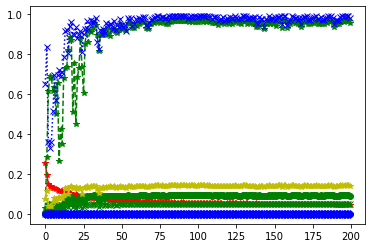

In [20]:
import matplotlib.pyplot as plt

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

plt.plot(test_losses_epoch, '*-r')

plt.plot(rouge1_precision_epoch, '*--g')
plt.plot(rouge1_recall_epoch, 'x--g')
plt.plot(rouge1_fmeasure_epoch, 'o--g')

plt.plot(bleu_avg_score_epoch, '*:b')
plt.plot(bleu_1_score_epoch, 'x:b')
plt.plot(bleu_2_score_epoch, '+:b')
plt.plot(bleu_3_score_epoch, 'o:b')
plt.plot(bleu_4_score_epoch, 'd:b')

plt.plot(meteor_score_epoch, '*-.y')

plt.show()

In [21]:
torch.save(model.state_dict(), save_model_file)

# Metrics

In [22]:
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")
n_tokens = len(WARNING_DL)
s_wte = SoftEmbedding(model.get_input_embeddings(), 
                      n_tokens=n_tokens, 
                      initialize_from_vocab=initialize_from_vocab)
model.set_input_embeddings(s_wte)

In [23]:
model.load_state_dict(torch.load("./output/LGP_soft_prompt_200_3407_1306_021205"))
if torch.cuda.is_available():
    model = model.to(device)

In [24]:
def eval_with_prompt(model, tokenizer, device, batch_size, n_tokens,
                     val_input, val_label, optimizer, ce_loss, use_ce_loss=False):
    dev_total_batch = math.ceil(len(val_input) / batch_size)
    
    all_true_labels = []
    all_pred_labels = []
    output_max_pred=[]
    test_losses = []
        
    with torch.no_grad():
            pbar = tqdm(enumerate(generate_data(batch_size, n_tokens, val_input, val_label, tokenizer, device)), total=dev_total_batch)
            for i, (x, y, m, dii, true_labels) in pbar:
                
                all_true_labels += true_labels
                outputs = model(input_ids=x, labels=y, attention_mask=m, decoder_input_ids=dii)

                output_ids=outputs.logits[:, n_tokens:, :]
                max_pred_ids=outputs.logits[:, n_tokens:, :].argmax(-1).detach().cpu().numpy().tolist()
                
                for i, (max_pred_ids_unbatch, output_ids_unbatch) in enumerate(zip(max_pred_ids, output_ids)):
                    max_pred_ids_unbatch=np.array(max_pred_ids_unbatch)
                    # output_ids[i]=output_ids_unbatch[max_pred_ids_unbatch!=0]
                    max_pred_ids[i]=max_pred_ids_unbatch[max_pred_ids_unbatch!=0].tolist()
                
#                 print("tokenizer.batch_decode(max_pred_ids)", tokenizer.batch_decode(max_pred_ids))
                output_max_pred.extend(tokenizer.batch_decode(max_pred_ids))
                # print("output_max_pred", output_max_pred)

                loss = outputs.loss
                loss_value = float(loss.detach().cpu().numpy().tolist()) / batch_size
                test_losses.append(loss_value)

                pred_labels = outputs['logits'][:, :, :].argmax(-1).detach().cpu().numpy().tolist()
                all_pred_labels += pred_labels
                pbar.set_description(f'dev: loss={np.mean(test_losses):.4f}')
                
    return output_max_pred

In [25]:
output_max_pred=eval_with_prompt(model, tokenizer, device, batch_size, n_tokens,
                     val_input=test_sensor_data, val_label=test_templates, optimizer=optimizer, ce_loss=ce_loss, use_ce_loss=False)
print(len(output_max_pred), len(output_max_pred[0]))

dev: loss=0.0464: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]

660 135


In [26]:
print(len(output_max_pred), output_max_pred[0])
print(len(test_sensor_data), test_sensor_data[0])
print(len(test_templates), test_templates[0])

660 (0:05) The drone is facing the risk of physical damage. It's a too close to drone at a distance at 0.5 0.5 the pilot is not experienced
660 {"time_stamp": "0:05", "name": NaN, "Distance": 0.5}
660 (0:05) The drone is facing the risk of physical damage. It's flying too close to nan at a distance of 0.5m, and the pilot is not experienced.


In [27]:
# predictions: An iterator over tokenized predictions. Each prediction is a list.
# [
#     ["michael", "dahlquist", "(", "december", "22", ",", "1965", "--", "july",
#      "14", ",", "2005", ")", "was", "a", "drummer", "in", "the", "california",
#      "band", "grateful", "dead", "."],
# ]
def __max_pred_as_generation(output_max_pred):
    result=[]
    for line in output_max_pred:
        tmp=[line.lower().split()]
        result.append(tmp)
        # print("__max_pred_as_generation_reader", tmp)
        
    return result
        
# references: An iterator over lists of tokenized references. Each prediction can have multiple references.
# [[
#     "michael", "dahlquist", "(", "december", "22", ",", "1965", "--", "july",
#     "14", ",", "2005", ")", "was", "a", "drummer", "in", "the", "seattle",
#     "band", "silkworm", "."
# ]]
def __template_as_refer(test_templates):
    result=[]
    for line in test_templates:
        tmp=line.lower().split()
        result.append(tmp)
        # print("__template_as_refer_reader", tmp)
        
    return result
        
# tables: An iterator over the tables
# TEST_TABLE = [
#     [["birth", "name"], ["michael", "dahlquist"]],
#     [["born"], ["december", "22", ",", "1965"]],
#     [["birth", "place"], ["seattle", ",", "washington"]],
#     [["died"], ["july", "14", ",", "2005"]],
#     [["death", "place"], ["skokie", ",", "illinois"]],
#     [["genres"], ["male"]],
#     [["occupation(s)"], ["drummer"]],
#     [["instruments"], ["drums"]],
# ]
def __sensor_data_as_table(test_sensor_data):
    result=[]
    for line in test_sensor_data:
        related_sensor_data=json.loads(line)
        # print("__sensor_data_as_table_reader related_sensor_data", related_sensor_data)
        
        tmp=[]
        for key, value in related_sensor_data.items():
            key_tokens=key.lower().split()
            value_tokens=str(value).lower().split()
            
#             print("__sensor_data_as_table_reader key", key)
#             print("__sensor_data_as_table_reader key_tokens", key_tokens)
            
#             print("__sensor_data_as_table_reader value", value)
#             print("__sensor_data_as_table_reader value_tokens", value_tokens)
            
            tmp.append([key_tokens, value_tokens])
        
        result.append(tmp)
        # print("__sensor_data_as_table_reader", tmp)
    
    return result

In [28]:
generation_it = __max_pred_as_generation(output_max_pred)
reference_it = __template_as_refer(test_templates)
table_it = __sensor_data_as_table(test_sensor_data)

print("generation_it", type(generation_it), generation_it[0], generation_it[:3])
print("reference_it", type(reference_it), reference_it[0], reference_it[:3])
print("table_it", type(table_it), table_it[0], table_it[:3])

generation_it <class 'list'> [['(0:05)', 'the', 'drone', 'is', 'facing', 'the', 'risk', 'of', 'physical', 'damage.', "it's", 'a', 'too', 'close', 'to', 'drone', 'at', 'a', 'distance', 'at', '0.5', '0.5', 'the', 'pilot', 'is', 'not', 'experienced']] [[['(0:05)', 'the', 'drone', 'is', 'facing', 'the', 'risk', 'of', 'physical', 'damage.', "it's", 'a', 'too', 'close', 'to', 'drone', 'at', 'a', 'distance', 'at', '0.5', '0.5', 'the', 'pilot', 'is', 'not', 'experienced']], [['(0:02)', 'the', 'drone', 'is', 'facing', 'the', 'risk', 'of', 'physical', 'damage.', 'it', 'is', 'a', 'too', 'in', 'to', 'the', "drone's", 'distance', 'distance', 'at', '0', 'distance', '0m.5.</s></s>']], [['the', 'flying', 'drone', 'is', 'runing', 'out', 'of', 'battery', 'with', 'only%%', 'charge.</s>']]]
reference_it <class 'list'> ['(0:05)', 'the', 'drone', 'is', 'facing', 'the', 'risk', 'of', 'physical', 'damage.', "it's", 'flying', 'too', 'close', 'to', 'nan', 'at', 'a', 'distance', 'of', '0.5m,', 'and', 'the', 'pil

In [29]:
parent_score_li=[]

for pred, refer, table in zip(generation_it, reference_it, table_it):
    # print("pred", type(pred), pred)
    # print("refer", type(refer), refer)
    # print("table", type(table), table)
    _, _, parent_score, _ = parent(pred, [[refer]], [table], lambda_weight=None)
    parent_score_li.append(parent_score)

print("parent_score_li", len(parent_score_li), parent_score_li[0])

parent_score_li 660 0.02038661519328828


In [26]:
entail_method=overlap_probability
precision, recall, f_score, all_f = parent(
    generation_it,
    [reference_it],
    table_it,
    lambda_weight=None,
    smoothing=0.00001,
    entailment_fn=entail_method)

print("precision", precision)
print("recall", recall)
print("f_score", f_score)
print("all_f", all_f)

TypeError: unhashable type: 'list'

In [70]:

TEST_PREDS = [[['(0:05)', 'the', 'drone', 'is', 'facing', 'the', 'risk', 'of', 'physical']], [['(0:02)', 'the', 'drone', 'is', 'facing']], [['the', 'flying', 'drone', 'is', 'runing', 'out', 'of', 'battery']]]
TEST_REF = [['(0:05)', 'the', 'drone', 'is', 'facing', 'the', 'risk', 'of', 'physical', 'damage.', "it's", 'flying', 'too', 'close', 'to', 'nan', 'at', 'a', 'distance', 'of', '0.5m,', 'and', 'the', 'pilot', 'is', 'not', 'experienced.'], ['(0:02)', 'the', 'drone', 'is', 'facing', 'the', 'risk', 'of', 'physical', 'damage.', "it's", 'flying', 'too', 'close', 'to', 'booth', 'at', 'a', 'distance', 'of', '0.5m,', 'and', 'the', 'pilot', 'is', 'not', 'experienced.'], ['the', 'flying', 'drone', 'is', 'runing', 'out', 'of', 'battery', 'with', 'only', '0%', 'charge.']]
TEST_TABLE = [[['time_stamp'], ['0:05']], [['name'], ['nan']], [['distance'], ['0.5']]], [[['time_stamp'], ['0:02']], [['name'], ['booth']], [['distance'], ['0.5']]], [[['battery_level'], ['0']]]

# _, _, parent_score, _=parent(TEST_PREDS, [TEST_REF], [TEST_TABLE], lambda_weight=None)
# print(parent_score)

def test_parent():
    for pred, score in zip(TEST_PREDS, TEST_SCORES):
      print("pred", type(pred), pred)
      print("prediction = %s" % " ".join(pred[0]))
      _, _, parent_score, _ = parent(pred, [TEST_REF],
                                                     [TEST_TABLE],
                                                     lambda_weight=None)
      print(parent_score)
      

test_parent()

pred <class 'list'> [['(0:05)', 'the', 'drone', 'is', 'facing', 'the', 'risk', 'of', 'physical']]
prediction = (0:05) the drone is facing the risk of physical


ValueError: not enough values to unpack (expected 3, got 1)

In [67]:

TEST_PREDS = [
    ["michael", "dahlquist", "(", "december", "22", ",", "1965", "--", "july",
     "14", ",", "2005", ")", "was", "a", "drummer", "in", "the", "california",
     "band", "grateful", "dead", "."],
]

TEST_REF = [
    "michael", "dahlquist", "(", "december", "22", ",", "1965", "--", "july",
    "14", ",", "2005", ")", "was", "a", "drummer", "in", "the", "seattle",
    "band", "silkworm", "."
]

TEST_TABLE = [
    [["birth", "name"], ["michael", "dahlquist"]],
    [["born"], ["december", "22", ",", "1965"]],
    [["birth", "place"], ["seattle", ",", "washington"]],
    [["died"], ["july", "14", ",", "2005"]],
    [["death", "place"], ["skokie", ",", "illinois"]],
    [["genres"], ["male"]],
    [["occupation(s)"], ["drummer"]],
    [["instruments"], ["drums"]],
]
TEST_SCORES = [0.772, 0.836, 0.848]



In [68]:
_, _, parent_score, _=parent(TEST_PREDS, [TEST_REF],TEST_TABLE,lambda_weight=None)
print(parent_score)

0.08476999753365962


In [69]:
def test_parent():
    for pred, score in zip(TEST_PREDS, TEST_SCORES):
      
      print("prediction = %s" % " ".join(pred))
        
      print("[pred]", type([pred]), [pred])
      print("[[TEST_REF]]", type([[TEST_REF]]), [[TEST_REF]])
      print("[TEST_TABLE]", type([TEST_TABLE]), [TEST_TABLE])
      _, _, parent_score, _ = parent([pred], [[TEST_REF]],
                                                     [TEST_TABLE],
                                                     lambda_weight=None)
      print(parent_score)

test_parent()

prediction = michael dahlquist ( december 22 , 1965 -- july 14 , 2005 ) was a drummer in the california band grateful dead .
[pred] <class 'list'> [['michael', 'dahlquist', '(', 'december', '22', ',', '1965', '--', 'july', '14', ',', '2005', ')', 'was', 'a', 'drummer', 'in', 'the', 'california', 'band', 'grateful', 'dead', '.']]
[[TEST_REF]] <class 'list'> [[['michael', 'dahlquist', '(', 'december', '22', ',', '1965', '--', 'july', '14', ',', '2005', ')', 'was', 'a', 'drummer', 'in', 'the', 'seattle', 'band', 'silkworm', '.']]]
[TEST_TABLE] <class 'list'> [[[['birth', 'name'], ['michael', 'dahlquist']], [['born'], ['december', '22', ',', '1965']], [['birth', 'place'], ['seattle', ',', 'washington']], [['died'], ['july', '14', ',', '2005']], [['death', 'place'], ['skokie', ',', 'illinois']], [['genres'], ['male']], [['occupation(s)'], ['drummer']], [['instruments'], ['drums']]]]
0.7717486485694235
